In [1]:
# Data manipulation, visualization, and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_ta as ta

# Fetches stock data from Yahoo!
import yfinance as yf



In [2]:
def main():
    # Grab data from Yahoo! Finance
    ticker = 'HD'  # The Home Depot
    start_date = '2021-07-21'
    end_date = '2024-10-11'
    data = yf.download(ticker, start=start_date, end=end_date)

    # Display first few rows of dataset
    print(f'First few rows of {ticker} dataset:')
    print(data.head())

    # Exploratory data analysis
    print('\nMissing values in dataset:')
    print(data.isnull().sum())
    print('\nSummary stats for dataset:')
    print(data.describe())

    # Calculate SMA, EMA
    data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20 Day SMA
    data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50 Day SMA
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()  # 20 day EMA

    # Calculate RSI
    delta = data['Close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Prevent division by zero
    data['RSI_14'] = 100 - (100 / (1 + rs))

    # Calculate MACD (12-day EMA - 26-day EMA)
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Generate buy/sell signals based on RSI and MACD
    data = generate_signals(data)

    # Create positions based on signals
    data = create_positions(data)

    # Calculate returns for backtesting
    data = calculate_returns(data)

    # Plot cumulative  returns of the strategy and the stock
    plot_cumulative_returns(data, ticker)

    # Evalulate performance
    evaluate_performance(data)
    annualized_returns(data)
    calculate_volatility(data)
    calculate_sharpe_ratio(data)



In [3]:
def generate_signals(data):
    data['Signal'] = 0

    # RSI-based signals
    data['Signal'] = np.where(data['RSI_14'] < 30, 1, data['Signal'])  # Buy when oversold
    data['Signal'] = np.where(data['RSI_14'] > 70, -1, data['Signal'])  # Sell when overbought

    # MACD-based signals
    macd_signal_change = pd.Series(np.where(data['MACD'] > data['MACD_Signal'], 1, 0), index=data.index)
    data['Signal'] = np.where((data['MACD'] < data['MACD_Signal']) & (macd_signal_change.shift(1) == 1), -1, data['Signal'])  # Sell Signal
    data['Signal'] = np.where((data['MACD'] > data['MACD_Signal']) & (macd_signal_change.shift(1) == 0), 1, data['Signal'])  # Buy Signal

    return data



In [4]:
def create_positions(data):
    # Position is set as a data series for last buy signal
    data['Position'] = pd.Series(data['Signal'], index=data.index).replace(to_replace=0, method='ffill').shift()
    data['Position'].fillna(0, inplace=True)

    return data



In [5]:
def calculate_returns(data):
    data['Stock_Returns'] = data['Close'].pct_change() # daily percentage change in stock closing price
    data['Strategy_Returns'] = data['Stock_Returns'] * data['Position'] #returns of strategy based on holding position or staying out of market

    # cumulative performance of stock and strategy over time
    data['Cumulative_Stock_Returns'] = (1 + data['Stock_Returns']).cumprod() - 1
    data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod() - 1

    return data



In [6]:
def plot_cumulative_returns(data, ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative_Stock_Returns'], label=f'{ticker} Stock Returns', color='blue')
    plt.plot(data.index, data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
    plt.title(f'{ticker} Cumulative Returns: Stock vs Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()



In [7]:

def evaluate_performance(data):
    # Total returns (final value of cumulative returns)
    total_stock_return = data['Cumulative_Stock_Returns'].iloc[-1]
    total_strategy_return = data['Cumulative_Strategy_Returns'].iloc[-1]

    print(f"Total Stock Return: {total_stock_return:.2%}")
    print(f"Total Strategy Return: {total_strategy_return:.2%}")

    return total_stock_return, total_strategy_return #return for use in annualized function



In [8]:

def annualized_returns(data, periods_per_year=252):
    total_days = len(data)
    total_stock_return = data['Cumulative_Stock_Returns'].iloc[-1]
    total_strategy_return = data['Cumulative_Strategy_Returns'].iloc[-1]

    annual_stock_return = (1 + total_stock_return) ** (periods_per_year / total_days) - 1
    annual_strategy_return = (1 + total_strategy_return) ** (periods_per_year / total_days) - 1

    print(f"Annualized Stock Return: {annual_stock_return:.2%}")
    print(f"Annualized Strategy Return: {annual_strategy_return:.2%}")



In [9]:

def calculate_volatility(data, _periods_per_year=252):
    # Annualized volatility formula: daily_std * sqrt(periods_per_year)
    stock_volatility = data['Stock_Returns'].std() * np.sqrt(_periods_per_year)
    strategy_volatility = data['Strategy_Returns'].std() * np.sqrt(_periods_per_year)

    print(f"Stock Volatility (Annualized): {stock_volatility:.2%}")
    print(f"Strategy Volatility (Annualized): {strategy_volatility:.2%}")




[*********************100%***********************]  1 of 1 completed
<ipython-input-4-743d0a293334>:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = pd.Series(data['Signal'], index=data.index).replace(to_replace=0, method='ffill').shift()
<ipython-input-4-743d0a293334>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Position'].fillna(0, inplace=True)


First few rows of HD dataset:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-07-21  327.600006  328.470001  324.970001  326.359985  301.136047   
2021-07-22  327.940002  327.970001  325.329987  326.660004  301.412842   
2021-07-23  329.470001  333.450012  327.940002  332.839996  307.115173   
2021-07-26  330.070007  331.559998  326.880005  331.179993  305.583496   
2021-07-27  331.790009  331.880005  326.059998  327.260010  301.966461   

             Volume  
Date                 
2021-07-21  2832600  
2021-07-22  2208100  
2021-07-23  2786400  
2021-07-26  2752000  
2021-07-27  2910300  

Missing values in dataset:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Summary stats for dataset:
             Open        High         Low       Close   Adj Close  \
count  812.000000  812.000000  812.000000  812.000000  812.000000   


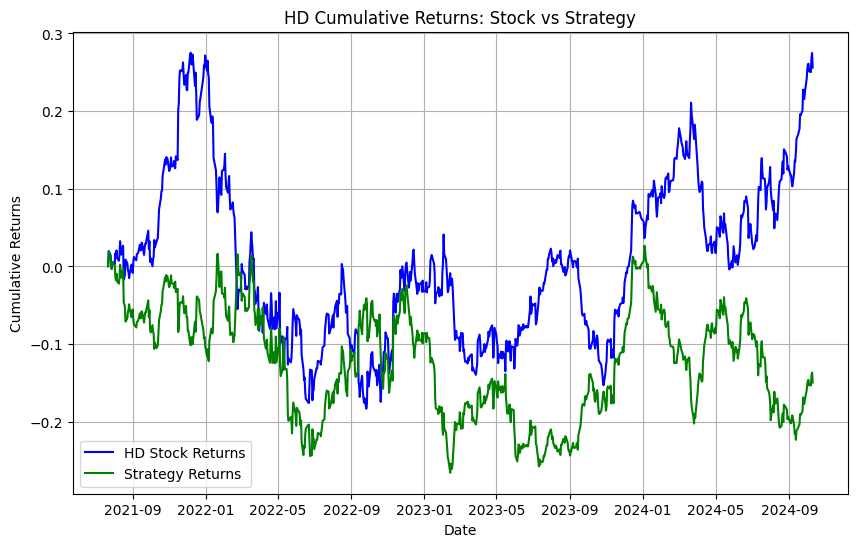

Total Stock Return: 25.62%
Total Strategy Return: -14.95%
Annualized Stock Return: 7.33%
Annualized Strategy Return: -4.90%
Stock Volatility (Annualized): 24.56%
Strategy Volatility (Annualized): 24.57%
Stock Sharpe Ratio: 0.37
Strategy Sharpe Ratio: -0.12


In [10]:
def calculate_sharpe_ratio(data, _risk_free_rate=0.01, _periods_per_year=252):
    # Excess returns
    excess_stock_return = data['Stock_Returns'] - _risk_free_rate / _periods_per_year
    excess_strategy_return = data['Strategy_Returns'] - _risk_free_rate / _periods_per_year

    # Sharpe ratio formula: mean(excess_return) / std_dev(excess_return) * sqrt(periods_per_year)
    stock_sharpe_ratio = (excess_stock_return.mean() / excess_stock_return.std()) * np.sqrt(_periods_per_year)
    strategy_sharpe_ratio = (excess_strategy_return.mean() / excess_strategy_return.std()) * np.sqrt(_periods_per_year)

    print(f"Stock Sharpe Ratio: {stock_sharpe_ratio:.2f}")
    print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")


if __name__ == '__main__':
    main()